In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim

import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

from sklearn.metrics import roc_auc_score

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device: {device}')

Device: cuda


# Sparsity Aware Model

In [2]:
class DualBranchNet(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=128, num_hidden_layers=2, dropout_rate=0.3):
        super(DualBranchNet, self).__init__()

        # Dynamically create shared feature extractor layers
        shared_layers = []
        in_features = input_dim
        for _ in range(num_hidden_layers):
            shared_layers.append(nn.Linear(in_features, hidden_dim))
            shared_layers.append(nn.BatchNorm1d(hidden_dim))
            shared_layers.append(nn.LeakyReLU())
            shared_layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_dim  # Update input size for next layer
        
        self.shared_layers = nn.Sequential(*shared_layers)

        # Classification branch (Binary classification for P(Y > 0))
        self.classification_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, output_dim),  # Output a single probability per target
            nn.Sigmoid()  # Outputs probability P(Y > 0)
        )

        # Regression branch (Predicts E[Y | Y > 0])
        self.regression_branch = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim // 2, output_dim),
            nn.ReLU()  # Ensures non-negative output
        )

    def forward(self, x):
        x = torch.log1p(x) # log transform X
        features = self.shared_layers(x)
        prob_y_positive = self.classification_branch(features)  # Probability P(Y > 0)
        y_regression = self.regression_branch(features)  # Expected Y given Y > 0
        return prob_y_positive, y_regression

    def predict(self, x):
        """Final Prediction: P(Y > 0) * E[Y | Y > 0]"""
        prob_y_positive, y_regression = self.forward(x)
        return prob_y_positive * y_regression

# Data

In [3]:
full_data = True

In [4]:
df_taxon = pd.read_parquet('../processed_data/taxon_coverage_s.parquet')

if full_data:
    taxons = ['s', 'g', 'f', 'c', 'o', 'p']
    for taxon in taxons:
        df_temp = pd.read_parquet(f'../processed_data/taxon_coverage_{taxon}.parquet')
        df_taxon = pd.concat([df_taxon, df_temp], axis=1)  # Concatenate along columns

df_genes = pd.read_parquet('../processed_data/gene_coverage_95.parquet')
df_genes = df_genes.set_index("Sample")

# force same order 
df_genes = df_genes.reindex(df_taxon.index)

In [5]:
df_taxon

,Bifidobacterium longum,Bifidobacterium infantis,Bifidobacterium breve,Bifidobacterium bifidum,Collinsella sp022728415,Bacteroides fragilis,Bacteroides stercoris,Bacteroides caccae,Phocaeicola vulgatus,Prevotella sp900543975,...,Caldisericota,UBA10199,Desulfobacterota_B,Myxococcota_A,KSB1,Cloacimonadota,Hydrogenedentota,Desulfobacterota_G,Riflebacteria,Desulfobacterota_D
ERR2835298,85.91,152.43,109.57,8.24,0.61,5.30,1.72,23.53,11.86,2.87,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR12302558,63.99,31.05,113.22,18.55,0.00,66.84,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13622751,125.85,99.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR15127829,419.87,545.92,55.28,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR12325043,109.82,287.97,5.50,31.63,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ERR3053399,0.00,165.16,9.36,9.84,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13774645,0.00,544.66,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13774552,0.00,1196.35,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SRR13774476,0.00,1986.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Preprocessing

In [6]:
count_genes   = (df_genes > 0).sum(0)
count_species = (df_taxon > 0).sum(0)

threshold = 200 # remove genes and taxon that show up less that threshold times in the data

df_taxon = df_taxon.loc[:, count_species > threshold]
df_genes = df_genes.loc[:, count_genes > threshold]

## Model Parameters

In [7]:
model = DualBranchNet(input_dim=df_taxon.shape[1], 
                      hidden_dim=1024, 
                      num_hidden_layers=4,
                      dropout_rate=0.3,
                      output_dim=df_genes.shape[1])

num_params = sum(param.numel() for param in model.parameters())

print(f'Model has {num_params:,} parameters')

Model has 118,185,332 parameters


# Training the Model

## Data to Tensors

In [8]:
X = torch.tensor(df_taxon.values, dtype=torch.float32)
Y = torch.tensor(df_genes.values, dtype=torch.float32)

# train val test split
train_ratio = 0.7
val_ratio   = 0.15
test_ration = 1 - (train_ratio + val_ratio) # doesn't matter because we'll keep the rest

num_samples = X.shape[0]
train_size = int(train_ratio * num_samples)
val_size = int(val_ratio * num_samples)
test_size = num_samples - train_size - val_size

indices = torch.randperm(num_samples)
train_idx, val_idx, test_idx = indices[:train_size], indices[train_size:train_size+val_size], indices[train_size+val_size:]

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

## Training Loop

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Jaccard Similarity Function
def jaccard_similarity(y_true, y_pred, threshold=0.5):
    """
    Compute the Jaccard Similarity (Intersection over Union) for multi-label classification.
    
    Args:
        y_true (Tensor): Ground truth binary labels (0 or 1).
        y_pred (Tensor): Predicted probabilities (before thresholding).
        threshold (float): Threshold to convert probabilities to binary predictions.
    
    Returns:
        float: Average Jaccard similarity over the batch.
    """
    y_pred_binary = (y_pred > threshold).float()
    intersection = (y_true * y_pred_binary).sum(dim=1)
    union = (y_true + y_pred_binary).clamp(0, 1).sum(dim=1)
    jaccard_scores = intersection / (union + 1e-6)  # Add small epsilon to avoid division by zero
    return jaccard_scores.mean().item()


# Training Setup
input_dim = X_train.shape[1]  # Number of input features
output_dim = Y_train.shape[1] # Number of target genes

hidden_dim = 1024
num_hidden_layers = 4
dropout_rate = 0.3
l2_reg = 1e-4  # Weight decay (L2 regularization)

# Instantiate Model
model = DualBranchNet(input_dim, output_dim, hidden_dim, num_hidden_layers, dropout_rate).to(device)

# Optimizer & Loss Functions
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=l2_reg)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)

bce_loss = nn.BCELoss()
mse_loss = nn.MSELoss()

# Convert Data to PyTorch DataLoader
batch_size = 64

train_dataset = TensorDataset(X_train, Y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(X_val, Y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training Parameters
epochs = 600
alpha = 0.5  # Weight for BCE loss vs. MSE loss
threshold = 0.5  # Threshold for Jaccard computation


# Lists to store training progress
bce_train_history = []
mse_train_history = []
jaccard_train_history = []

bce_val_history = []
mse_val_history = []
jaccard_val_history = []

# Training Loop
for epoch in range(epochs):
    model.train()
    total_bce_loss_train = 0
    total_mse_loss_train = 0
    total_jaccard_train = 0

    # Training Phase
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()

        #### First pass - Classification update (BCE) ####
        prob_y_positive, y_regression = model(x_batch)

        target_binary = (y_batch > 0).float()  # Binary mask
        loss_classification = bce_loss(prob_y_positive, target_binary)

        # Compute Jaccard similarity
        jaccard_score = jaccard_similarity(target_binary, prob_y_positive, threshold)

        # Perform gradient update for BCE
        loss_classification.backward()
        optimizer.step()

        total_bce_loss_train += loss_classification.item()
        total_jaccard_train += jaccard_score

        #### Second pass - Regression update (MSE) ####
        optimizer.zero_grad()  # Clear gradients again

        # Forward pass again
        prob_y_positive, y_regression = model(x_batch)

        # Compute MSE only for positive Y
        mask = target_binary.bool()  # Convert to boolean mask
        if mask.sum() > 0:  # If there are positive values
            loss_regression = mse_loss(y_regression[mask], y_batch[mask])
        else:
            loss_regression = torch.tensor(0.0, device=device)

        # Perform gradient update for MSE
        loss_regression.backward()
        optimizer.step()

        total_mse_loss_train += loss_regression.item()

    #### Validation Phase ####
    model.eval()
    total_bce_loss_val = 0
    total_mse_loss_val = 0
    total_jaccard_val = 0

    with torch.no_grad():
        for batch in val_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            prob_y_positive, y_regression = model(x_batch)

            target_binary = (y_batch > 0).float()

            # Compute BCE Loss
            loss_classification = bce_loss(prob_y_positive, target_binary)
            total_bce_loss_val += loss_classification.item()

            # Compute Jaccard Similarity
            jaccard_score = jaccard_similarity(target_binary, prob_y_positive, threshold)
            total_jaccard_val += jaccard_score

            # Compute MSE Loss
            mask = target_binary.bool()
            if mask.sum() > 0:
                loss_regression = mse_loss(y_regression[mask], y_batch[mask])
            else:
                loss_regression = torch.tensor(0.0, device=device)

            total_mse_loss_val += loss_regression.item()

    #### Logging & Storing Metrics ####
    num_train_batches = len(train_loader)
    num_val_batches = len(val_loader)

    avg_bce_train = total_bce_loss_train / num_train_batches
    avg_mse_train = total_mse_loss_train / num_train_batches
    avg_jaccard_train = total_jaccard_train / num_train_batches

    avg_bce_val = total_bce_loss_val / num_val_batches
    avg_mse_val = total_mse_loss_val / num_val_batches
    avg_jaccard_val = total_jaccard_val / num_val_batches

    # Store the metrics for plotting
    bce_train_history.append(avg_bce_train)
    mse_train_history.append(avg_mse_train)
    jaccard_train_history.append(avg_jaccard_train)

    bce_val_history.append(avg_bce_val)
    mse_val_history.append(avg_mse_val)
    jaccard_val_history.append(avg_jaccard_val)

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"  Train -> BCE: {avg_bce_train:.4f}, MSE: {avg_mse_train:.4f}, Jaccard: {avg_jaccard_train:.4f}")
    print(f"  Val   -> BCE: {avg_bce_val:.4f}, MSE: {avg_mse_val:.4f}, Jaccard: {avg_jaccard_val:.4f}")

Epoch 1/600
  Train -> BCE: 0.6581, MSE: 21552.5751, Jaccard: 0.4357
  Val   -> BCE: 0.5900, MSE: 18382.0409, Jaccard: 0.5394
Epoch 2/600
  Train -> BCE: 0.5929, MSE: 17187.5396, Jaccard: 0.5752
  Val   -> BCE: 0.5053, MSE: 14961.4137, Jaccard: 0.6048
Epoch 3/600
  Train -> BCE: 0.4978, MSE: 16873.4316, Jaccard: 0.6052
  Val   -> BCE: 0.4980, MSE: 14099.2937, Jaccard: 0.6160
Epoch 4/600
  Train -> BCE: 0.4891, MSE: 16829.7448, Jaccard: 0.6061
  Val   -> BCE: 0.4707, MSE: 13079.5073, Jaccard: 0.6141
Epoch 5/600
  Train -> BCE: 0.4866, MSE: 16376.5709, Jaccard: 0.6078
  Val   -> BCE: 0.4783, MSE: 13061.0412, Jaccard: 0.6150
Epoch 6/600
  Train -> BCE: 0.4871, MSE: 16106.0528, Jaccard: 0.6075
  Val   -> BCE: 0.4817, MSE: 13330.3618, Jaccard: 0.6191
Epoch 7/600
  Train -> BCE: 0.4866, MSE: 16388.6186, Jaccard: 0.6091
  Val   -> BCE: 0.4674, MSE: 13644.7988, Jaccard: 0.6160
Epoch 8/600
  Train -> BCE: 0.4875, MSE: 16248.8665, Jaccard: 0.6094
  Val   -> BCE: 0.4720, MSE: 13161.2546, Jaccard:

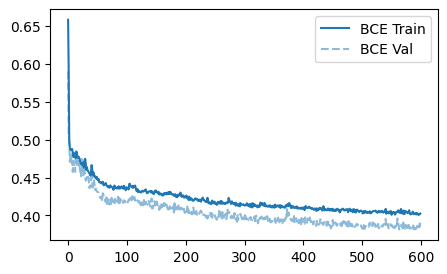

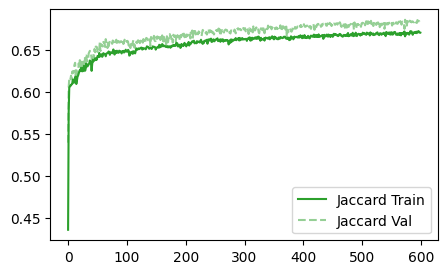

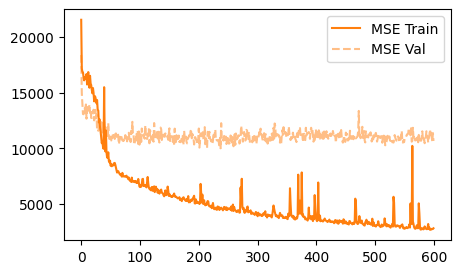

In [10]:
plt.figure(figsize=(5, 3))
plt.plot(bce_train_history, ls='-', label='BCE Train', color='C0')
plt.plot(bce_val_history, ls='--', label='BCE Val', color='C0', alpha=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(jaccard_train_history, ls='-', label='Jaccard Train', color='C2')
plt.plot(jaccard_val_history, ls='--',  label='Jaccard Val', color='C2', alpha=0.5)
plt.legend()
plt.show()

plt.figure(figsize=(5, 3))
plt.plot(mse_train_history, ls='-', label='MSE Train', color='C1')
plt.plot(mse_val_history, ls='--',  label='MSE Val', color='C1', alpha=0.5)
plt.legend()
plt.show()

In [11]:
# Save the model
torch.save(model.state_dict(), 'model.pth')

# Load the model
model.load_state_dict(torch.load('model.pth'), strict=False)
model.eval()  # Set to evaluation mode if needed

/tmp/slurm-4115552/ipykernel_1508833/2319020382.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'), strict=False)


DualBranchNet(
  (shared_layers): Sequential(
    (0): Linear(in_features=312, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.3, inplace=False)
    (12): Linear(in_features=1024, out_features=1024, bias=True)
    (13): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): LeakyReLU(negative_slope=0.01)
    (15): Dropout(p=0.3, inplace=False)
  )
  (classi

# Evaluation

In [12]:
model.eval()

with torch.no_grad():
    prob_y_positive, _ = model(X_test.to(device)) 

all_preds_np = prob_y_positive.cpu().numpy()
all_labels_np = (Y_test.cpu().numpy() > 0).astype(int)

num_outputs = all_preds_np.shape[1]
roc_aucs = np.full(num_outputs, np.nan)  # Initialize with NaNs

for i in tqdm(range(num_outputs)):
    if len(np.unique(all_labels_np[:, i])) > 1:  # Ensure at least two classes exist
        roc_aucs[i] = roc_auc_score(all_labels_np[:, i], all_preds_np[:, i])

100%|█████████████████████████████████| 110778/110778 [01:07<00:00, 1641.69it/s]


## Classification

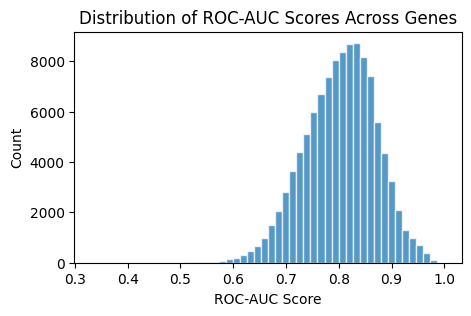

Mean ROC-AUC Score: 0.8028005485998384


In [18]:
plt.figure(figsize=(5, 3))
plt.hist(roc_aucs[~np.isnan(roc_aucs)], bins=50, alpha=0.75, edgecolor='white')
plt.xlabel("ROC-AUC Score")
plt.ylabel("Count")
plt.title("Distribution of ROC-AUC Scores Across Genes")
plt.show()

print(f'Mean ROC-AUC Score: {np.mean(roc_aucs[~np.isnan(roc_aucs)])}')

In [14]:
np.isnan(roc_aucs).sum()

np.int64(18)

### Correlation between Gene Frequency in samples and ROC-AUC

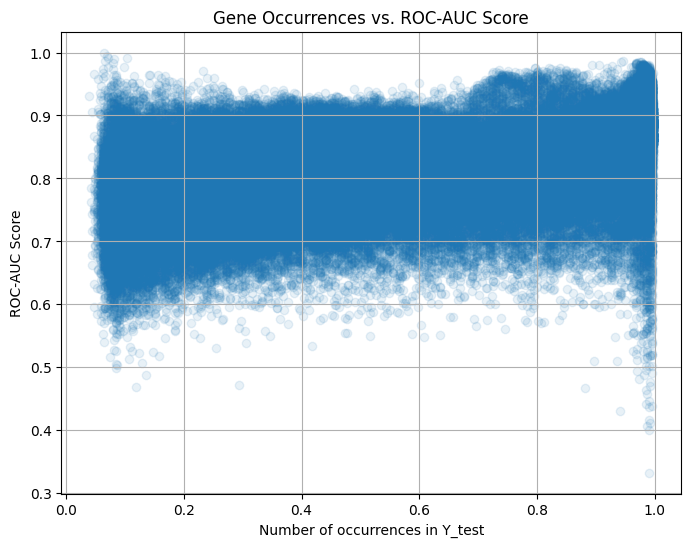

In [15]:
gene_occurrences = np.count_nonzero(Y_test.cpu().numpy(), axis=0)

valid_indices = ~np.isnan(roc_aucs)
filtered_occurrences = gene_occurrences[valid_indices]
filtered_roc_aucs = roc_aucs[valid_indices]

plt.figure(figsize=(8, 6))
plt.scatter(filtered_occurrences/Y_test.shape[0], filtered_roc_aucs, alpha=0.1)
plt.xlabel("Number of occurrences in Y_test")
plt.ylabel("ROC-AUC Score")
plt.title("Gene Occurrences vs. ROC-AUC Score")
# plt.xscale("log")  # Log scale for better visualization if needed
plt.grid(True)
plt.show()

## Regression

In [16]:
import numpy as np
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from scipy.stats import spearmanr
from tqdm import tqdm

model.eval()

with torch.no_grad():
    y_pred = model.predict(X_test.to(device))

# Move everything to CPU for evaluation
y_pred_np = y_pred.cpu().numpy()
y_true_np = Y_test.cpu().numpy()

num_outputs = y_pred_np.shape[1]

# Compute Metrics
mse_values = np.full(num_outputs, np.nan)
mae_values = np.full(num_outputs, np.nan)
r2_values = np.full(num_outputs, np.nan)
spearman_corrs = np.full(num_outputs, np.nan)
explained_var = np.full(num_outputs, np.nan)

for i in tqdm(range(num_outputs), desc="Evaluating Regression Quality"):
    y_true_col = y_true_np[:, i]
    y_pred_col = y_pred_np[:, i]

    # Check if the target values vary
    if np.var(y_true_col) > 0:
        mse_values[i] = mean_squared_error(y_true_col, y_pred_col)
        mae_values[i] = mean_absolute_error(y_true_col, y_pred_col)
        r2_values[i] = r2_score(y_true_col, y_pred_col)
        explained_var[i] = explained_variance_score(y_true_col, y_pred_col)

        # Only compute Spearman correlation if there is variation
        if len(np.unique(y_true_col)) > 1 and len(np.unique(y_pred_col)) > 1:
            spearman_corrs[i] = spearmanr(y_true_col, y_pred_col).correlation

print("\n**Overall Regression Evaluation:**")
print(f"Mean MSE: {np.nanmean(mse_values):.6f}")
print(f"Mean MAE: {np.nanmean(mae_values):.6f}")
print(f"Mean R² Score: {np.nanmean(r2_values):.6f}")
print(f"Mean Spearman Correlation: {np.nanmean(spearman_corrs):.6f}")
print(f"Mean Explained Variance: {np.nanmean(explained_var):.6f}")

Evaluating Regression Quality: 100%|███| 110778/110778 [02:42<00:00, 681.48it/s]


**Overall Regression Evaluation:**
Mean MSE: 5465.951608
Mean MAE: 10.560218
Mean R² Score: -0.035330
Mean Spearman Correlation: 0.310982
Mean Explained Variance: -0.014404


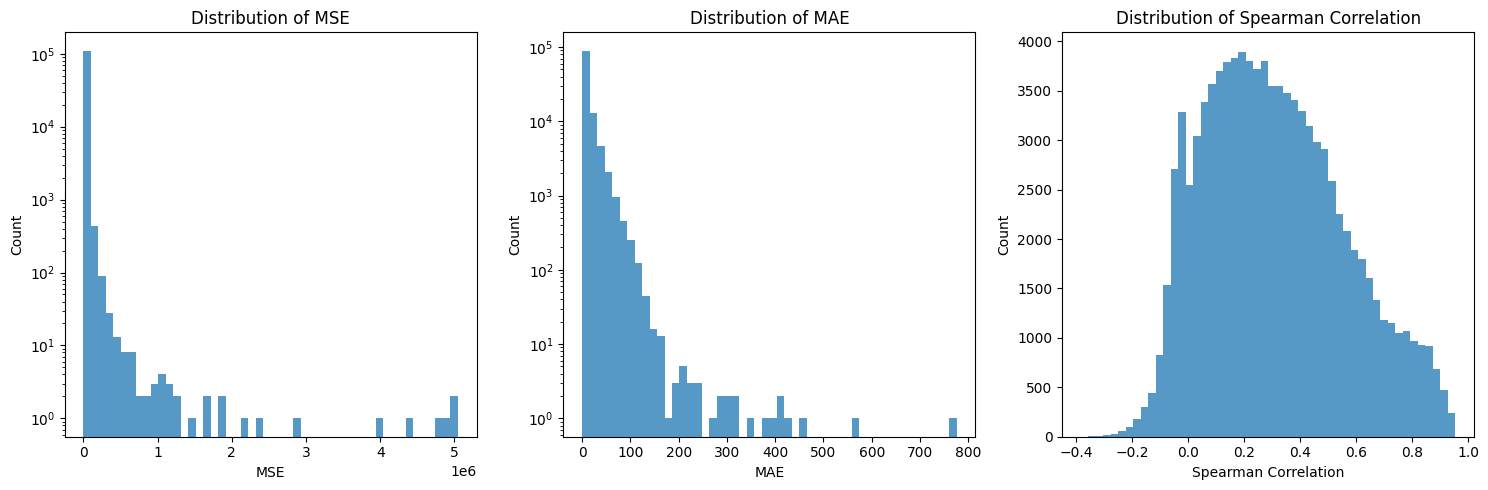

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# MSE Distribution
plt.subplot(1, 3, 1)
plt.hist(mse_values[~np.isnan(mse_values)], bins=50, alpha=0.75)
plt.xlabel("MSE")
plt.ylabel("Count")
plt.yscale('log')
plt.title("Distribution of MSE")

# MAE Distribution
plt.subplot(1, 3, 2)
plt.hist(mae_values[~np.isnan(mae_values)], bins=50, alpha=0.75)
plt.xlabel("MAE")
plt.ylabel("Count")
plt.yscale('log')
plt.title("Distribution of MAE")

# Spearman Correlation Distribution
plt.subplot(1, 3, 3)
plt.hist(spearman_corrs[~np.isnan(spearman_corrs)], bins=50, alpha=0.75)
plt.xlabel("Spearman Correlation")
plt.ylabel("Count")
plt.title("Distribution of Spearman Correlation")

plt.tight_layout()
plt.show()


# Mixture Density Networks

For regression, because what if there's no function f(X) = Y (maybe its an inverse problem oof sorts. In the same community, bifidus might assume different functional roles that are arbitrarily "chosen").

See [here](https://publications.aston.ac.uk/id/eprint/373/1/NCRG_94_004.pdf).